<a href="https://colab.research.google.com/github/shreysingla11/3D-project/blob/master/Siamese_handgestures_25_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D,Dropout
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy.random as rng
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.utils import shuffle
%matplotlib inline
def W_init(shape,dtype=None):
    """Initialize weights as in paper"""
    values = rng.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,dtype=dtype)
#//TODO: figure out how to initialize layer biases in keras.
def b_init(shape,dtype=None):
    """Initialize bias as in paper"""
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,dtype=dtype)

input_shape = (105, 105, 3)
left_input = Input(input_shape)
right_input = Input(input_shape)
#build convnet to use in each siamese 'leg'
convnet = Sequential()
convnet.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape,
                   kernel_initializer=W_init,kernel_regularizer=l2(2e-4)))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(7,7),activation='relu',
                   kernel_regularizer=l2(2e-4),kernel_initializer=W_init,bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(128,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Conv2D(256,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
convnet.add(MaxPooling2D())
convnet.add(Flatten())
convnet.add(Dense(512,activation="sigmoid",kernel_regularizer=l2(2e-4),kernel_initializer=W_init,bias_initializer=b_init))

#call the convnet Sequential model on each of the input tensors so params will be shared
encoded_l = convnet(left_input)
encoded_r = convnet(right_input)
#layer to merge two encoded inputs with the l1 distance between them
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
#call this layer on list of two input tensors.
L1_distance = L1_layer([encoded_l, encoded_r])
prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(L1_distance)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

optimizer = Adam(0.00004)
#//TODO: get layerwise learning rates and momentum annealing scheme described in paperworking
siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer)

siamese_net.summary()


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 105, 105, 3)  0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 105, 105, 3)  0                                            
__________________________________________________________________________________________________
sequential_6 (Sequential)       (None, 512)          2387776     input_11[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 512)          0           sequential_6[1][0]         

In [47]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [48]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:

data_path = '/content/gdrive/My Drive/Handgestures-25'
train_path = os.path.join(data_path,'train')
valid_path = os.path.join(data_path,'valid')

def loadimgs(path):
    if path == '/content/gdrive/My Drive/Handgestures-25/train':
        X = np.zeros((25,200,105,105,3))
    else:
        X = np.zeros((25,50,105,105,3))
    labels = {}
    for i,name in enumerate(os.listdir(path)):
        print(i)
        print(name)
        class_path = os.path.join(path,name)
        print(len(os.listdir(class_path)))
        labels[name] = i
        for j,f in enumerate(os.listdir(class_path)):
            #print(f)
            img_path = os.path.join(class_path,f)
            img = cv2.imread(img_path)
            X[i,j,:,:,:] = img
    return X,labels

In [50]:
X,c = loadimgs(train_path)
Xval,cval = loadimgs(valid_path)
data = [X,c,Xval,cval]

0
fist
200
1
catch
200
2
one
200
3
cross-two
200
4
six
200
5
prayer
200
6
cross-one
200
7
five
200
8
rock
200
9
fantastic
200
10
two
200
11
gun
200
12
four
200
13
interlocked
200
14
pinch
200
15
thumb
200
16
three
200
17
timeout
200
18
together
200
19
bird
200
20
heart
200
21
diamond
200
22
seven
200
23
fist-two
200
24
heart-two
200
0
six
50
1
cross-two
50
2
pinch
50
3
prayer
50
4
one
50
5
fist
50
6
fantastic
50
7
two
50
8
catch
50
9
five
50
10
interlocked
50
11
rock
50
12
together
50
13
four
50
14
gun
50
15
three
50
16
cross-one
50
17
thumb
50
18
heart-two
50
19
fist-two
50
20
bird
50
21
seven
50
22
timeout
50
23
heart
50
24
diamond
50


In [0]:
class Siamese_Loader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self,data):
        self.data = {}
        self.categories = {}
        self.info = {}
        self.data['train'] = data[0]
        self.categories['train'] = data[1]
        self.data['val'] = data[2]
        self.categories['val'] = data[3]
        
    def get_batch(self,batch_size,s="train"):
        """Create batch of n pairs, half same class, half different class"""
        X=self.data[s]
        n_classes, n_examples, w, h ,ch = X.shape

        #randomly sample several classes to use in the batch
        categories = rng.choice(n_classes,size=(batch_size,),replace=True)
        #initialize 2 empty arrays for the input image batch
        pairs=[np.zeros((batch_size, h, w, 3)) for i in range(2)]
        #initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
        targets=np.zeros((batch_size,))
        targets[batch_size//2:] = 1
        for i in range(batch_size):
            category = categories[i]
            idx_1 = rng.randint(0, n_examples)
            pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 3)
            idx_2 = rng.randint(0, n_examples)
            #pick images of same class for 1st half, different for 2nd
            if i >= batch_size // 2:
                category_2 = category  
            else: 
                #add a random number to the category modulo n classes to ensure 2nd image has
                # ..different category
                category_2 = (category + rng.randint(1,n_classes)) % n_classes
            pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h, 3)
        return pairs, targets    

    
    def generate(self, batch_size, s="train"):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = self.get_batch(batch_size,s)
            yield (pairs, targets)    

    def make_oneshot_task(self,N,s="val"):
        if N>25:
            print('exceeds number of classes')
            return
        else:
            X = self.data[s]
            n_classes,n_examples,w,h,c = X.shape
            indices = rng.randint(0,n_examples,size=(N,))
            categories = rng.choice(n_classes,size=(N,),replace=False)
            true_category = categories[0]
            ex1,ex2 = rng.choice(n_examples,replace=False,size=(2,))
            test_image = np.asarray([X[true_category,ex1,:,:,:]]*N).reshape(N,w,h,3)
            support_set = X[categories,indices,:,:,:]
            support_set[0,:,:,:] = X[true_category,ex2]
            support_set = support_set.reshape(N,w,h,3)
            targets = np.zeros((N,))
            targets[0] = 1
            targets, test_image, support_set = shuffle(targets, test_image, support_set)
            pairs = [test_image,support_set]
            return pairs, targets
        
    def test_oneshot(self,model,N,k,s="val",verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        if verbose:
            pass
            #print("Evaluating model on {} random {} way one-shot learning tasks ...".format(k,N))
        for i in range(k):
            inputs, targets = self.make_oneshot_task(N,s)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy".format(percent_correct,N))
        return percent_correct
    
    def train(self, model, epochs, verbosity):
        model.fit_generator(self.generate(batch_size))

In [0]:
loader = Siamese_Loader(data)

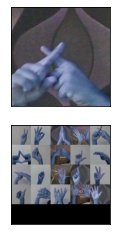

In [53]:

def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc,w,h,ch = X.shape
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h,3))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h,:] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img


def plot_oneshot_task(pairs):
    """Takes a one-shot task given to a siamese net and  """
    fig,(ax1,ax2) = plt.subplots(2)
    ax1.imshow(pairs[0][0].reshape(105,105,3).astype('uint8'))
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.imshow(img.astype('uint8'))
    plt.xticks([])
    plt.yticks([])
    plt.show()
#example of a one-shot learning task
pairs, targets = loader.make_oneshot_task(20,"train")
plot_oneshot_task(pairs)


In [54]:

#Training loop
print("!")
training_losses = []
val_accs = []
evaluate_every = 100 # interval for evaluating on one-shot tasks``
loss_every=100 # interval for printing loss (iterations)
batch_size = 64
n_iter = 10000
PATH = '/content/gdrive/My Drive'
N_way = 25 # how many classes for testing one-shot tasks>
n_val = 400 #how mahy one-shot tasks to validate on?
best = -1
weights_path = os.path.join(PATH, "weights.h5")
print("training")
for i in range(1, n_iter):
    (inputs,targets)=loader.get_batch(batch_size)
    loss=siamese_net.train_on_batch(inputs,targets)
    #print(loss)
    if i % evaluate_every == 0:
        print("evaluating")
        val_acc = loader.test_oneshot(siamese_net,N_way,n_val,verbose=True)
        val_accs.append(val_acc)
        if val_acc >= best:
            #print("saving")
            siamese_net.save(weights_path)
            best=val_acc

    if i % loss_every == 0:
        training_losses.append(loss)
        print("iteration {}, training loss: {:.4f},".format(i,loss))


!
training
evaluating
Got an average of 13.75% 25 way one-shot learning accuracy
iteration 100, training loss: 0.7294,
evaluating
Got an average of 16.75% 25 way one-shot learning accuracy
iteration 200, training loss: 0.6987,
evaluating
Got an average of 13.75% 25 way one-shot learning accuracy
iteration 300, training loss: 0.6174,
evaluating
Got an average of 15.25% 25 way one-shot learning accuracy
iteration 400, training loss: 0.5210,
evaluating
Got an average of 26.25% 25 way one-shot learning accuracy
iteration 500, training loss: 0.4975,
evaluating
Got an average of 34.5% 25 way one-shot learning accuracy
iteration 600, training loss: 0.4364,
evaluating
Got an average of 32.5% 25 way one-shot learning accuracy
iteration 700, training loss: 0.4492,
evaluating
Got an average of 40.0% 25 way one-shot learning accuracy
iteration 800, training loss: 0.4278,
evaluating
Got an average of 46.25% 25 way one-shot learning accuracy
iteration 900, training loss: 0.2801,
evaluating
Got an av

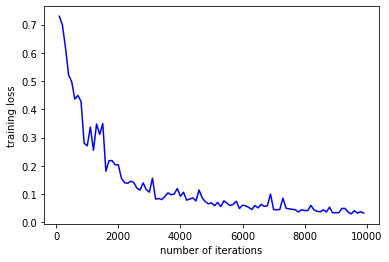

In [56]:
iters = range(100,10000,100)
plt.plot(iters,training_losses,'b-')
plt.xlabel('number of iterations')
plt.ylabel('training loss')
plt.show()

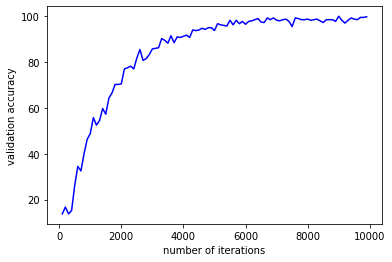

In [57]:
plt.plot(iters,val_accs,'b-')
plt.xlabel('number of iterations')
plt.ylabel('validation accuracy')
plt.show()

Got an average of 100.0% 1 way one-shot learning accuracy
Got an average of 100.0% 1 way one-shot learning accuracy
Got an average of 100.0% 2 way one-shot learning accuracy
Got an average of 100.0% 2 way one-shot learning accuracy
Got an average of 99.8% 3 way one-shot learning accuracy
Got an average of 100.0% 3 way one-shot learning accuracy
Got an average of 99.9% 4 way one-shot learning accuracy
Got an average of 100.0% 4 way one-shot learning accuracy
Got an average of 99.7% 5 way one-shot learning accuracy
Got an average of 100.0% 5 way one-shot learning accuracy
Got an average of 99.8% 6 way one-shot learning accuracy
Got an average of 99.9% 6 way one-shot learning accuracy
Got an average of 99.8% 7 way one-shot learning accuracy
Got an average of 100.0% 7 way one-shot learning accuracy
Got an average of 99.6% 8 way one-shot learning accuracy
Got an average of 100.0% 8 way one-shot learning accuracy
Got an average of 99.7% 9 way one-shot learning accuracy
Got an average of 100.

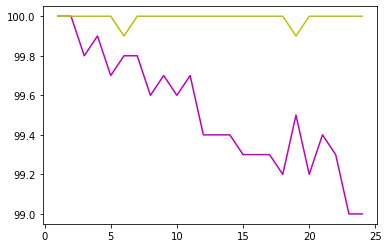

In [58]:
ways = np.arange(1, 25, 1)
resume =  False
val_accs, train_accs = [], []
trials = 1000
for N in ways:
    val_accs.append(loader.test_oneshot(siamese_net, N,trials, "val", verbose=True))
    train_accs.append(loader.test_oneshot(siamese_net, N,trials, "train", verbose=True))
    
#plot the accuracy vs num categories for each
plt.plot(ways, val_accs, "m")
plt.plot(ways, train_accs, "y")
plt.show()

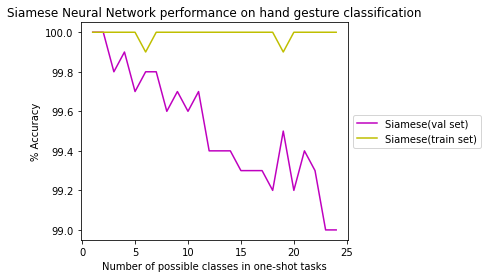

(20, 105, 105, 3)


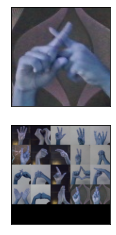

[[2.7959000e-12]
 [3.2853467e-07]
 [2.5529760e-06]
 [4.9621364e-13]
 [3.4813827e-10]
 [2.0596316e-10]
 [7.2204019e-04]
 [3.8030322e-04]
 [3.5896883e-10]
 [9.7364327e-06]
 [9.9157518e-01]
 [3.1048164e-02]
 [5.8390973e-03]
 [1.9671310e-02]
 [1.6725851e-04]
 [4.2956740e-06]
 [1.1847856e-01]
 [9.1067771e-11]
 [1.0049914e-05]
 [2.9942853e-09]]


In [60]:
fig,ax = plt.subplots(1)
ax.plot(ways,val_accs,"m",label="Siamese(val set)")
ax.plot(ways,train_accs,"y",label="Siamese(train set)")

plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Siamese Neural Network performance on hand gesture classification")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
inputs,targets = loader.make_oneshot_task(20,"val")
plt.show()

print(inputs[0].shape)
plot_oneshot_task(inputs)
p=siamese_net.predict(inputs)
print(p)